# Super-Resolution

**Resnets vs VGG:**

The problem when using resnets as backbone for tasks like *super-resolution* or *segmentation* is that the first 7x7 stride 2 convolution throws away half of the image and therefore most of the fine structure that contains valuable information.

1. VGG has a HUGE fully connected layer at the top which takes lots of memory.
2. Resnets have an adaptive pooling layer at the end that throws away any kind of spatial information (other extreme).

We therefore use VGG today because we want to preserve this fine structure. We actually use a more modern version that incluces batch norm layers.

In [1]:
%matplotlib inline

In [2]:
from fastai.conv_learner import *
from pathlib import Path

In [3]:
torch.backends.cudnn.benchmark = True

In [4]:
arch = vgg16
#scale = 2
scale = 4
sz_low_res = 72
sz_high_res = sz_low_res * scale

## Data

In [5]:
PATH = Path('data/imagenet')

In [6]:
TRAIN_PATH = PATH/'train'

In [7]:
filenames, label_arr, labels = folder_source(PATH, 'train')

In [8]:
filenames[:3]

['train/n01440764/n01440764_9649.JPEG',
 'train/n01440764/n01440764_63.JPEG',
 'train/n01440764/n01440764_8063.JPEG']

In [9]:
filenames = ['/'.join(Path(fn).parts[-2:]) for fn in filenames]

`Path('train/n01440764/n01440764_9649.JPEG').parts[-2:]` gives `('n01440764', 'n01440764_9649.JPEG')`

In [10]:
filenames[:3]

['n01440764/n01440764_9649.JPEG',
 'n01440764/n01440764_63.JPEG',
 'n01440764/n01440764_8063.JPEG']

In [11]:
label_arr

array([  0,   0,   0, ..., 773, 773, 773])

In [12]:
labels[:3]

['n01440764', 'n01443537', 'n01491361']

In [13]:
Path('train/n01440764/n01440764_9649.JPEG').parts[-2:]

('n01440764', 'n01440764_9649.JPEG')

### Create a small subset for experimentation

In [14]:
np.random.seed(42)
# keep_perct = 1.
keep_perct = 0.02
keep_indcs = np.random.rand(len(filenames)) < keep_perct
filenames = np.array(filenames, copy=False)[keep_indcs]
label_arr = np.array(label_arr, copy=False)[keep_indcs]

In [15]:
class MatchedFilesDataset(FilesDataset):  # overrides the fastai FilesDataset class
    def __init__(self, fnames, y, transform, path):
        self.y = y
        assert(len(fnames) == len(y))
        super().__init__(fnames, transform, path)
    def get_y(self, i):                   # get_y must be overriden so that the label is an image too!
        return open_image(os.path.join(self.path, self.y[i]))
    def get_c(self):
        return 0

In [16]:
augment_tfms = [RandomDihedral(tfm_y=TfmType.PIXEL)]

1. `TfmType.Pixel` makes sure that the label image receives the same transformations as the input image.
1. Dihedral group of order 8: all possible 90 degree rotations + flips. Normally we would not want to use such a transform for a dataset like imagenet because those images are usually not seen upside down. This would make more sense for satellite data etc. Here it does not matter because we are not trying to classifiy but enhance the resolution.

In [17]:
val_indcs = get_cv_idxs(len(filenames), val_pct=min(0.01/keep_perct, 0.1))

In [18]:
((val_x,trn_x),(val_y,trn_y)) = split_by_idx(val_indcs, np.array(filenames), np.array(filenames))
# do this with sklearn's train test split function

In [19]:
len(trn_x), len(val_x)

(347, 38)

In [20]:
tfms = tfms_from_model(arch, sz_low_res, tfm_y=TfmType.PIXEL, aug_tfms=augment_tfms, sz_y=sz_high_res)

In [21]:
datasets = ImageData.get_ds(MatchedFilesDataset, (trn_x,trn_y), (val_x,val_y), tfms, path=TRAIN_PATH)

In [22]:
bs = 24

In [23]:
modeldata = ImageData(PATH, datasets, bs, num_workers=12, classes=None)

### Let's take a look at a data pair

In [24]:
def show_img(img, idx, figsize=(5,5), normed=True, ax=None):
    if ax is None: fig, ax = plt.subplots(figsize=figsize)
    if normed: img = modeldata.val_ds.denorm(img)
    else: img = to_np(img).transpose(1,2,0)
    ax.imshow(np.clip(img, 0, 1)[idx])
    ax.axis('off')

In [25]:
x, y = next(iter(modeldata.val_dl))

In [26]:
x.size(), y.size()

(torch.Size([24, 3, 72, 72]), torch.Size([24, 3, 144, 144]))

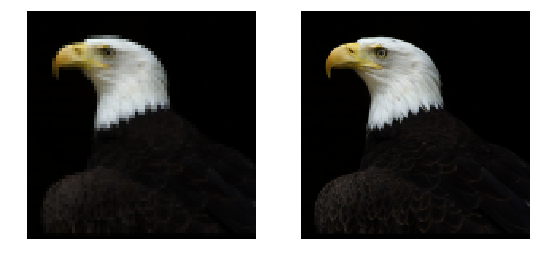

In [27]:
idx = 1
fig, axes = plt.subplots(1, 2, figsize=(9,5))
show_img(x, idx, ax=axes[0])
show_img(y, idx, ax=axes[1])

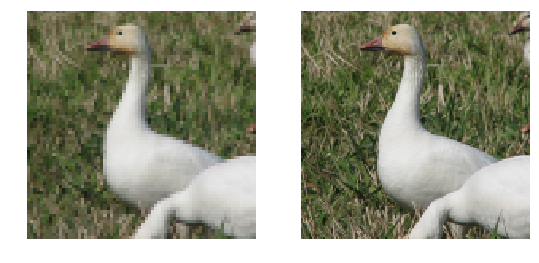

In [28]:
idx = 3
fig, axes = plt.subplots(1, 2, figsize=(9,5))
show_img(x, idx, ax=axes[0])
show_img(y, idx, ax=axes[1])

## Model

Some thoughts:
1. The input and output are really similar. Use resnet blocks because they have an *identity path*!
1. We could upsample first and then do a few conv layers that keep the size the same or first do a first conf layers that keep the size the same and then upsample. We do the second because it should be faster since the conv layers operate on the smaller image size and second because there should be lots of processed information that the network can ĺeverage while increasing the size.
1. Increasing the size could be done by 1) transposed convolutions or 2) upsampling followed by 1x1 conv and 3) PixelShuffel (Shi et al. 2016). We choose 3) because transposed convolutions leave artifacts and neartest neighbour upsampling involves lots of redundancy (conv layers operating on copied pixels). Note that even PixelShuffle leaves checkerboard artifacts unless the conv weights of all r^2 filters that are shuffled into one new filter are initialized the same.
1. One improvement suggested by the paper *Enhanced Deep Residual Networks for Single Image Super-Resolution* is to remove any batch-norm layers in order to best preserve the identity path given by the resnet blocks.

In [25]:
def ConvBlock(ni, nf, kernel_size=3, actn=True):
    layers = [nn.Conv2d(ni, nf, kernel_size, padding=kernel_size//2)]
    if actn: layers.append(nn.ReLU(True))
    return nn.Sequential(*layers)

In [26]:
class ResSequential(nn.Module):
    def __init__(self, layers, res_scale=1.0):
        super().__init__()
        self.res_scale = res_scale
        self.m = nn.Sequential(*layers)
        
    def forward(self, x):
        x = x + self.m(x) * self.res_scale
        return x

Multiplying the residual part of the resnet block by a small scaling factor has been found to greatly stabilize training when learning with very large batch sizes/large learning rates and was used by the *Enhanced Deep Residual Networks for Single Image Super-Resolution* as well.

In [27]:
def ResBlock(nf):
    return ResSequential([ConvBlock(nf, nf), ConvBlock(nf, nf, actn=False)], res_scale=0.1)

In [28]:
def upsample(n_in, n_out, scale):
    layers = []
    for i in range(int(math.log(scale, 2))):
        layers += [ConvBlock(n_in, n_out * 4), nn.PixelShuffle(2)]  # scaling factor is 2 therefore 2^2 * n_out
    return nn.Sequential(*layers)

In [29]:
class SuperResolutionResnet(nn.Module):
    def __init__(self, nf=64, scale=2.0):
        super().__init__()
        features = [ConvBlock(3, nf)]  # create 64 from the 3 input channels
        for i in range(8):
            features.append(ResBlock(nf))  # followed by 8 residual blocks that leave the shape the same
        features += [ConvBlock(nf, nf), upsample(nf, nf, scale),  # one more conv block, then upsample
                    nn.BatchNorm2d(nf), ConvBlock(nf, 3, actn=False)]  # finally reduce to 3 filters
        self.features = nn.Sequential(*features)
        
    def forward(self, x):
        return self.features(x)

## Loss function

### Pixel loss

In [34]:
model = SuperResolutionResnet(64, scale).cuda()

If you have several GPUs: `model = nn.DataParallel(model, [0,1])`

In [35]:
learn = Learner(modeldata, SingleModel(model), opt_fn=optim.Adam)

In [36]:
learn.crit = F.mse_loss

In [37]:
lr = 2e-3

In [38]:
learn.fit(lr, 10, cycle_len=1, use_clr_beta=(40,10))

epoch      trn_loss   val_loss                             
    0      0.756614   0.30093   
    1      0.472624   0.200481                             
    2      0.34174    0.167029                             
    3      0.269404   0.147952                             
    4      0.224542   0.141507                             
    5      0.195888   0.125747                             
    6      0.172427   0.114108                             
    7      0.154271   0.10167                              
    8      0.138613   0.096969                             
    9      0.125671   0.090851                             



[0.09085088184005335]

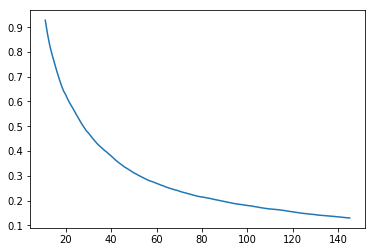

In [39]:
learn.sched.plot_loss()

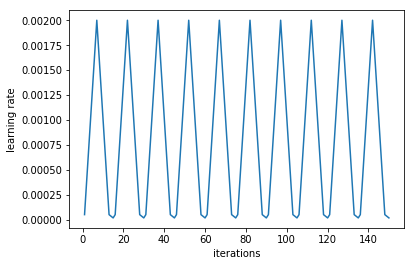

In [40]:
learn.sched.plot_lr()  # Leslie Smith 'one cycle lr'

In [41]:
x, y = next(iter(modeldata.val_dl))

In [42]:
preds = model(V(x, requires_grad=False))

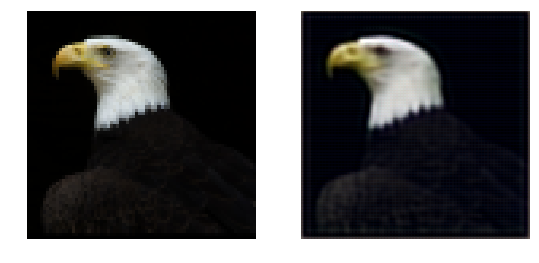

In [43]:
idx = 1
fig, axes = plt.subplots(1, 2, figsize=(9,5))
show_img(x, idx, ax=axes[0])
show_img(preds, idx, ax=axes[1])

**So basically we build a neural net that *blurs* images. But in principle this is what we asked it to do because the mse is likely very low when the low res image is simply blurred. => We need a better suited loss function**

### Perceptual loss

In order to remove the checkerboard artifacts that remain when using `nn.PixelShuffle` we dont initallize all conv kernels randomly but initialize one kernel randomly and then copy it several times.

In [30]:
def icnr(x, scale=2, init=nn.init.kaiming_normal):
    new_shape = [int(x.shape[0] / (scale ** 2))] + list(x.shape[1:])
    subkernel = torch.zeros(new_shape)
    subkernel = init(subkernel)
    subkernel = subkernel.transpose(0, 1)
    subkernel = subkernel.contiguous().view(subkernel.shape[0],
                                            subkernel.shape[1], -1)
    kernel = subkernel.repeat(1, 1, scale ** 2)
    transposed_shape = [x.shape[1]] + [x.shape[0]] + list(x.shape[2:])
    kernel = kernel.contiguous().view(transposed_shape)
    kernel = kernel.transpose(0, 1)
    return kernel

For perceptual loss we take a pretrained convnet in evaluation mode, apply it to x and y and then compare activations of later layers.

In [31]:
model_vgg = vgg16(pre=True)

In [32]:
blocks = [i - 1 for i, o in enumerate(list(model_vgg.children())) if isinstance(o, nn.MaxPool2d)]

In [33]:
blocks, [model_vgg[i] for i in blocks]

([5, 12, 22, 32, 42],
 [ReLU(inplace), ReLU(inplace), ReLU(inplace), ReLU(inplace), ReLU(inplace)])

Let's take only the first two of those and truncate the rest in order to save compute:

In [34]:
vgg_layers = list(model_vgg.children())[:13]

In [35]:
model_vgg = nn.Sequential(*vgg_layers).cuda().eval()

In [36]:
set_trainable(model_vgg, False)

In [37]:
def flatten(x):
    return x.view(x.size(0), -1)  # preserve only the batch dimension

Install forward hooks to grab the activations from the forward pass through the vgg network:

In [38]:
class SaveFeatures():
    features = None
    def __init__(self, module): self.hook = module.register_forward_hook(self.hook_fn)
    def hook_fn(self, module, input, output): self.features = output
    def remove(self): self.hook.remove()

In [39]:
class PerceptualLoss(nn.Module):
    def __init__(self, model, layer_ids, layer_weights):
        super().__init__()
        self.model = model
        self.weights = layer_weights
        self.saveFeatues = [SaveFeatures(model[i]) for i in layer_ids]
        
    def forward(self, input, target, sum_layers=True):
        # Down weighted pixel loss
        res = [F.l1_loss(input, target) / 100]
        
        # Get activations of target
        self.model(V(target.data, requires_grad=False))  # throw output away
        targ_act = [V(o.features.data.clone()) for o in self.saveFeatues]  # and grab activations from hooks.
        # here we need to clone in order to no overwrite the activations in the next forward pass with 'input'
        
        # Get activations of input
        self.model(input)
        input_act = [o.features for o in self.saveFeatues]
        
        res += [F.l1_loss(flatten(inp), flatten(targ)) * wgt for inp, targ, wgt in zip(input_act, targ_act, self.weights)]
        
        if sum_layers: res = sum(res)
        return res
    
    def close(self):
        for o in self.saveFeatues: o.remove()

#### Scale = 2

In [72]:
model = SuperResolutionResnet(64, scale)

Now we need to do the *icnr* initialization of the layer preceeding the `nn.PixelShuffle` in order to avoid the checkerboard artifacts. Let's first figure out the layer:

In [73]:
model.features[10]

Sequential(
  (0): Sequential(
    (0): Conv2d(64, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
  )
  (1): PixelShuffle(upscale_factor=2)
)

Ok, this is the one.

In [74]:
conv_shuffle = model.features[10][0][0]
conv_shuffle

Conv2d(64, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))

In [75]:
kernel = icnr(conv_shuffle.weight, scale=scale)
conv_shuffle.weight.data.copy_(kernel);

/home/fabiograetz/anaconda3/envs/deeplearning/lib/python3.6/site-packages/ipykernel/__main__.py:4: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.


In [76]:
model.cuda();

In [77]:
learn = Learner(modeldata, SingleModel(model), opt_fn=optim.Adam)

In [78]:
learn.crit = PerceptualLoss(model_vgg, blocks[:2], [0.26, 0.74])

In [40]:
lr=6e-3
wd=1e-7

In [85]:
learn.fit(lr, 10, cycle_len=1, wds=wd, use_clr=(20,10))

epoch      trn_loss   val_loss                              
    0      0.083025   0.077079  
    1      0.077799   0.071844                              
    2      0.074674   0.068441                              
    3      0.072309   0.068244                              
    4      0.069698   0.065074                              
    5      0.067385   0.062554                              
    6      0.065809   0.061998                              
    7      0.064177   0.060544                              
    8      0.062635   0.0599                                
    9      0.061522   0.059372                              



[0.059372390571393464]

In [90]:
learn.fit(lr, 10, cycle_len=1, wds=wd, use_clr=(20,10))

epoch      trn_loss   val_loss                              
    0      0.065253   0.061492  
    1      0.062194   0.059997                              
    2      0.060723   0.059189                              
    3      0.060571   0.059652                              
    4      0.060642   0.060673                              
    5      0.06025    0.05971                               
    6      0.059698   0.05878                               
    7      0.058756   0.058192                              
    8      0.057996   0.057503                              
    9      0.057048   0.056634                              



[0.05663421416753217]

In [91]:
x, y = next(iter(modeldata.val_dl))

In [92]:
preds = model(V(x, requires_grad=False))

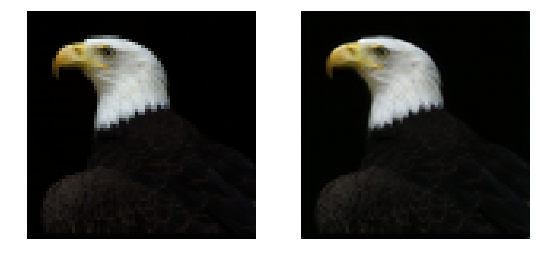

In [93]:
idx = 1
fig, axes = plt.subplots(1, 2, figsize=(9,5))
show_img(x, idx, ax=axes[0])
show_img(preds, idx, ax=axes[1])

In [94]:
learn.save('sr_scale2')

In [95]:
learn.load('sr_scale2')

### Scale == 4

Ok, this is looking pretty good already :)

**Now we increase the scale from 2 to 4 but we leverage the already trained network! This means, however, that when loading the model, we are missing weights for one `upsample` layer. Therefore set `strict` equals to false when loading.**

**Important notice in case someone codes along to this notebook: at this point you need to go to the top of the notebook, increase `scale` from 2 to 4 and run the next few cells to create a new dataset!**

In [41]:
x, y = next(iter(modeldata.val_dl))

In [42]:
x.size(), y.size()

(torch.Size([24, 3, 72, 72]), torch.Size([24, 3, 288, 288]))

Size of labels  was 144x144 before!

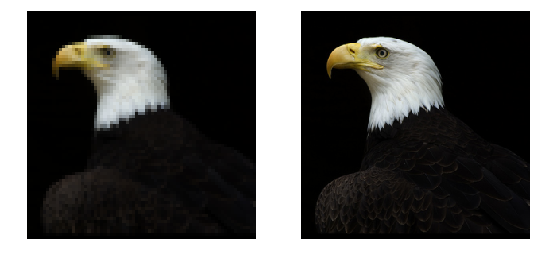

In [43]:
idx = 1
fig, axes = plt.subplots(1, 2, figsize=(9,5))
show_img(x, idx, ax=axes[0])
show_img(y, idx, ax=axes[1])

**This is x and y.**

In [44]:
model = SuperResolutionResnet(64, scale)

In [45]:
model.cuda();

In [46]:
learn = Learner(modeldata, SingleModel(model), opt_fn=optim.Adam)

In [47]:
t = torch.load(learn.get_model_path('sr_scale2'), map_location=lambda storage, loc: storage)
learn.model.load_state_dict(t, strict=False)

**There is a new upsample layer now that we need to initialize again!**

In [48]:
model.features[10]

Sequential(
  (0): Sequential(
    (0): Conv2d(64, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
  )
  (1): PixelShuffle(upscale_factor=2)
  (2): Sequential(
    (0): Conv2d(64, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
  )
  (3): PixelShuffle(upscale_factor=2)
)

**This is the one:**

In [49]:
conv_shuffle = model.features[10][2][0]

In [50]:
conv_shuffle

Conv2d(64, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))

In [51]:
kernel = icnr(conv_shuffle.weight, scale=scale)
conv_shuffle.weight.data.copy_(kernel);

/home/fabiograetz/anaconda3/envs/deeplearning/lib/python3.6/site-packages/ipykernel/__main__.py:4: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.


**This leaves us with another problem. We have a pretrained network now with one *untrained* layer in the middle. We need to freeze the entire network and than unfreeze the top layers beginning with the new layer and then only train these unfrozen layers.**

In [52]:
learn.freeze_to(999)  # Freeze all layers

**These layers need to be trained now:**

In [53]:
model.features[10:]

Sequential(
  (10): Sequential(
    (0): Sequential(
      (0): Conv2d(64, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace)
    )
    (1): PixelShuffle(upscale_factor=2)
    (2): Sequential(
      (0): Conv2d(64, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace)
    )
    (3): PixelShuffle(upscale_factor=2)
  )
  (11): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (12): Sequential(
    (0): Conv2d(64, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
)

In [54]:
for i in range(10, 13):
    set_trainable(model.features[i], True)

In [55]:
learn.crit = PerceptualLoss(model_vgg, blocks[:2], [0.26,0.74])

In [56]:
learn.fit(lr, 10, cycle_len=1, wds=wd, use_clr=(20,10))

epoch      trn_loss   val_loss                              
    0      0.095475   0.086342  
    1      0.086085   0.081014                              
    2      0.084394   0.080331                              
    3      0.081881   0.078475                              
    4      0.080796   0.078725                              
    5      0.080064   0.077199                              
    6      0.080105   0.079143                              
    7      0.078242   0.075803                              
    8      0.077082   0.076136                              
    9      0.076146   0.076001                              



[0.07600063242410358]

In [63]:
learn.save('sr_scale4')

In [67]:
learn.load('sr_scale4')

In [69]:
lr = 1e-3

In [71]:
learn.fit(lr, 10, cycle_len=1, wds=wd, use_clr=(20,10))

epoch      trn_loss   val_loss                              
    0      0.071138   0.074219  
    1      0.070463   0.074007                              
    2      0.06998    0.073206                              
    3      0.069717   0.073336                              
    4      0.069742   0.073113                              
    5      0.069473   0.073309                              
    6      0.069662   0.073055                              
    7      0.069505   0.072715                              
    8      0.06948    0.072885                              
    9      0.069183   0.072862                              



[0.07286195692263152]

In [77]:
learn.save('sr_scale4_2')

In [78]:
learn.load('sr_scale4_2')

In [73]:
x, y = next(iter(modeldata.val_dl))

In [74]:
preds = model(V(x, requires_grad=False))

In [75]:
x.shape, preds.shape

(torch.Size([24, 3, 72, 72]), torch.Size([24, 3, 288, 288]))

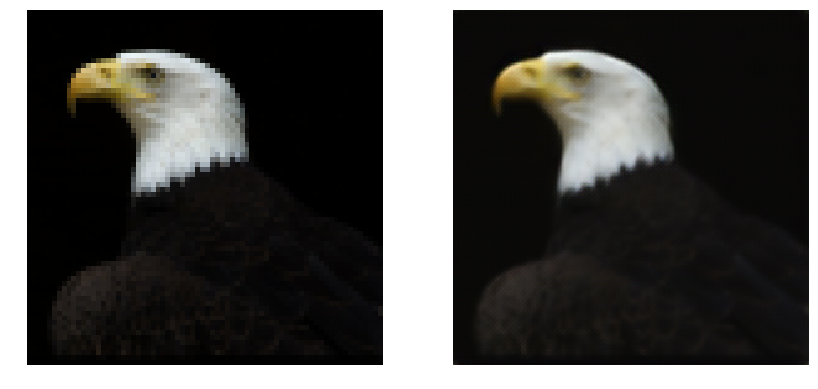

In [80]:
idx = 1
fig, axes = plt.subplots(1, 2, figsize=(14,7))
show_img(x, idx, ax=axes[0])
show_img(preds, idx, ax=axes[1])

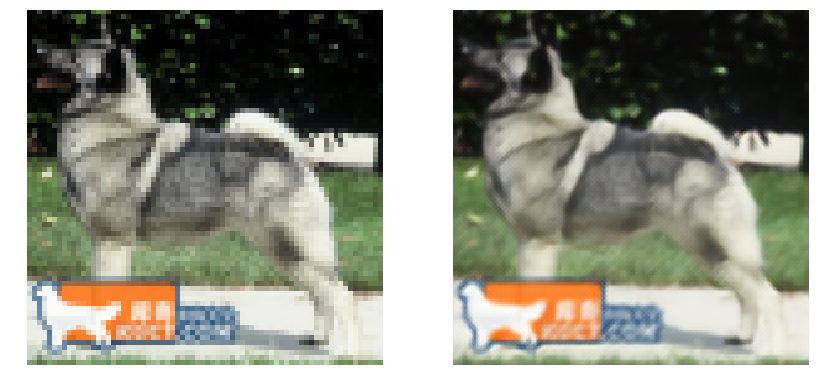

In [89]:
idx = 8
fig, axes = plt.subplots(1, 2, figsize=(14,7))
show_img(x, idx, ax=axes[0])
show_img(preds, idx, ax=axes[1])

**I think that this example is incredibly impressive: in the picture on the left the *.COM* is defenitely not readable at all.**

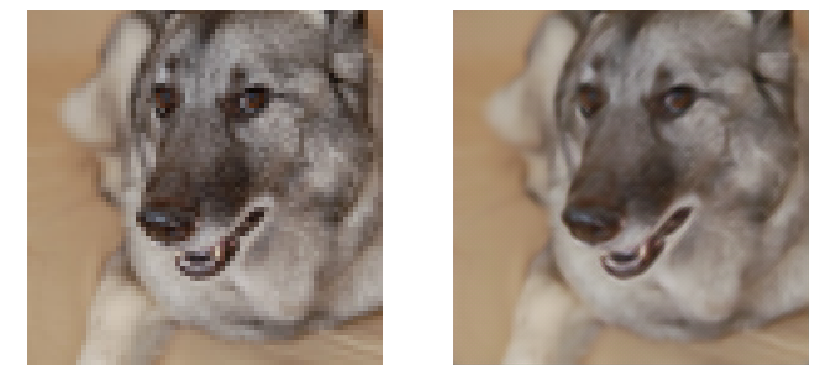

In [90]:
idx = 9
fig, axes = plt.subplots(1, 2, figsize=(14,7))
show_img(x, idx, ax=axes[0])
show_img(preds, idx, ax=axes[1])

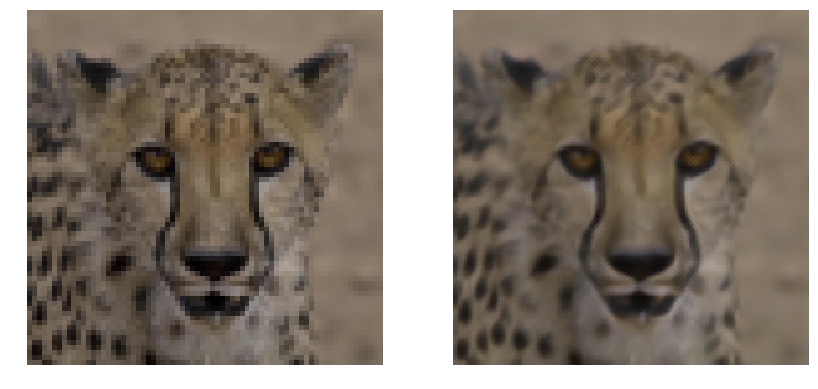

In [106]:
idx = 11
fig, axes = plt.subplots(1, 2, figsize=(14,7))
show_img(x, idx, ax=axes[0])
show_img(preds, idx, ax=axes[1])

In [79]:
learn.crit.close()  # Remove the hooks